In [30]:
import numpy as np
import pandas as pd
import uproot
import matplotlib.pyplot as plt
from hep_ml import reweight
from hep_ml.metrics_utils import ks_2samp_weighted
from sklearn.model_selection import train_test_split

In [37]:
sharedColums = ["gamma_PT","piminus_PT","B_P","B_ETA","piminus_IP_OWNPV","B_MINIPCHI2","B_FD_OWNPV","B_Cone3_B_ptasy","nTracks"]

columns    = {"kpi"  : sharedColums + ["Kplus_IP_OWNPV", "Kplus_PT", "Kst_892_0_PT","Kst_892_0_IP_OWNPV"],
              "pipi" : sharedColums + ["piplus_IP_OWNPV","piplus_PT","rho_770_0_PT","rho_770_0_IP_OWNPV"]}

modes      = ["kpi","kpisw", "pipi"]
histStyle  = {"bins" : 100, "density" : True, "alpha" :0.5}
colors     = {"kpi" : "#0062ff", "kpisw"  : "#d60645",  "pipi" : "#279c03", "ratio":"#000000"}

In [23]:
dataframes  = {}
path = "/Users/finnjohnonori/Documents/GitHubRepositories/MScProject/data/"

# Imports the Kpi monte carlo data - Original
with uproot.open(path + "kpiG_MC_Bd2KstGamma_HighPt_prefilter_2018_noPIDsel-magup.root") as Kpi_TChain_MC_up: # type: ignore
    Kpi_TTree_up         = Kpi_TChain_MC_up["DecayTree"]
    Kpi_up_MC_df         = Kpi_TTree_up.arrays(columns["kpi"], library="pd", aliases ={"B_ETA": "-log(tan(atan(B_PT/B_PZ)/2))"}) # type: ignore

with uproot.open(path + "kpiG_MC_Bd2KstGamma_HighPt_prefilter_2018_noPIDsel-magdown.root") as Kpi_TChain_MC_down: # type: ignore
    Kpi_TTree_MC_down    = Kpi_TChain_MC_down["DecayTree"]
    Kpi_down_MC_df       = Kpi_TTree_MC_down.arrays(columns["kpi"], library="pd", aliases ={"B_ETA": "-log(tan(atan(B_PT/B_PZ)/2))"}) # type: ignore

dataframes["kpi"]   = pd.concat((Kpi_up_MC_df, Kpi_down_MC_df))

#Import the pipi monte carlo data
with uproot.open(path + "pipiG_MC_Bd2RhoGamma_HighPt_prefilter_2018_noPIDsel-magup.root") as pipi_TChain_MC_up: # type: ignore
    pipi_TTree_MC_up     = pipi_TChain_MC_up["DecayTree"]
    pipi_up_MC_df        = pipi_TTree_MC_up.arrays(columns["pipi"], library="pd", aliases ={"B_ETA": "-log(tan(atan(B_PT/B_PZ)/2))"}) # type: ignore

with uproot.open(path + "pipiG_MC_Bd2RhoGamma_HighPt_prefilter_2018_noPIDsel-magdown.root") as pipi_TChain_MC_down: # type: ignore
    pipi_TTree_MC_down   = pipi_TChain_MC_down["DecayTree"]
    pipi_down_MC_df      = pipi_TTree_MC_down.arrays(columns["pipi"], library="pd", aliases ={"B_ETA": "-log(tan(atan(B_PT/B_PZ)/2))"}) # type: ignore

dataframes["pipi"]  = pd.concat((pipi_up_MC_df, pipi_down_MC_df))

#Imports the Sample Data - Target
with uproot.open(path + "Sample_Kpigamma_2018_selectedTree_with_sWeights_Analysis_2hg_Unbinned-Mask1.root") as Kpi_TChain_SM: # type: ignore
    Kpi_TTree_SM         = Kpi_TChain_SM["DecayTree"]

dataframes["kpisw"] = Kpi_TTree_SM.arrays(columns["kpi"] + ["NB0_Kpigamma_sw"], library="pd", cut = "(abs(B_M01-895.55)<100)", aliases ={"B_ETA": "-log(tan(atan(B_PT/B_PZ)/2))"}) # type: ignore
dataframes["kpisw"] = dataframes["kpisw"].reset_index(drop=True)

print("Data has been loaded")

Data has been loaded


In [24]:
dataframes["kpisw"]

,gamma_PT,piminus_PT,B_P,B_ETA,piminus_IP_OWNPV,B_MINIPCHI2,B_FD_OWNPV,B_Cone3_B_ptasy,nTracks,Kplus_IP_OWNPV,Kplus_PT,Kst_892_0_PT,Kst_892_0_IP_OWNPV,NB0_Kpigamma_sw
0,5580.989268,1540.491319,118143.120111,3.426983,0.216713,2.722780,2.591814,-0.273129,88,0.132774,1624.068647,3125.361732,0.168748,-0.105435
1,4903.816136,5446.451902,85212.952783,2.571472,0.216082,6.529346,3.120807,0.610176,78,0.268699,2710.643726,8157.577006,0.232694,-0.182308
2,6808.692446,1729.446314,73815.003277,2.773743,0.405056,1.980562,4.637549,0.496131,123,0.233188,1797.266341,3494.213838,0.307477,1.122087
3,3594.754062,2895.241634,108577.074580,3.115231,0.141697,3.079663,2.676955,0.188409,157,0.181036,4084.713045,6964.500699,0.164075,-0.024048
4,5295.953056,1166.800096,200845.209241,4.068222,0.263564,2.135752,18.321382,0.152623,101,0.511384,2122.395290,3248.755504,0.417048,1.234927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147831,5279.370695,4705.539939,162225.580446,3.084651,0.913931,2.746616,24.664219,0.607822,92,0.597558,5018.703616,9725.126933,0.735528,1.345144
147832,3011.381187,1839.067205,139175.793659,4.653456,0.507076,7.704228,14.859409,-0.533808,150,0.477578,882.639906,2719.356156,0.498148,1.329153
147833,3469.502011,769.487818,70858.626133,3.386582,0.277166,6.719201,15.860565,-0.415240,159,0.632575,1532.028492,2198.519734,0.487996,-0.372117
147834,3866.922343,585.076082,64263.155707,3.488037,1.849550,2.686864,15.519701,-0.064881,84,1.086756,1844.783941,2427.515931,1.195568,1.301266


In [25]:
dataframes["kpi"] 

,gamma_PT,piminus_PT,B_P,B_ETA,piminus_IP_OWNPV,B_MINIPCHI2,B_FD_OWNPV,B_Cone3_B_ptasy,nTracks,Kplus_IP_OWNPV,Kplus_PT,Kst_892_0_PT,Kst_892_0_IP_OWNPV
0,7018.973127,2298.157129,273883.848744,3.587485,0.195850,0.392829,7.153876,0.660959,60,0.102431,5980.988377,8280.136094,0.125250
1,7018.973127,5980.988377,273883.848744,3.587485,0.102431,0.392829,7.153876,0.660959,60,0.195850,2298.157129,8280.136094,0.125250
2,7158.783755,2188.554096,126785.577724,3.211112,1.494048,2.893996,13.858021,0.543079,107,0.612183,986.901536,3164.205027,1.141339
3,6545.822352,4558.507548,100415.996715,2.554097,0.412559,8.310109,10.304591,0.551857,131,0.393813,5193.613137,9750.204155,0.388003
4,6545.822352,5193.613137,100415.996715,2.554097,0.393813,8.310109,10.304591,0.551857,131,0.412559,4558.507548,9750.204155,0.388003
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105804,3954.462812,6277.329459,84931.574490,2.321838,0.250190,0.451742,5.578162,0.587744,243,0.186056,6995.922892,13261.808297,0.213293
105805,6168.203203,1463.252400,136018.777381,3.217236,0.461360,2.407127,18.615648,0.083082,189,0.656324,3705.990062,5168.330307,0.596333
105806,6168.203203,3705.990062,136018.777381,3.217236,0.656324,2.407127,18.615648,0.083082,189,0.461360,1463.252400,5168.330307,0.596333
105807,5078.961409,6856.574867,77078.946405,2.489899,0.196109,2.150364,4.061175,-0.097834,206,0.285272,1634.762010,8485.719181,0.208610


In [26]:
dataframes["pipi"] 

,gamma_PT,piminus_PT,B_P,B_ETA,piminus_IP_OWNPV,B_MINIPCHI2,B_FD_OWNPV,B_Cone3_B_ptasy,nTracks,piplus_IP_OWNPV,piplus_PT,rho_770_0_PT,rho_770_0_IP_OWNPV
0,9404.979350,5932.422191,203192.901927,3.192779,0.932925,3.174901,32.615943,0.356671,117,1.942544,1601.844343,7534.618494,1.075677
1,3750.709052,1943.098019,63947.891308,2.606804,0.240746,0.219817,4.642332,0.193075,85,0.549385,4440.708598,6368.717620,0.437346
2,3935.534861,1717.707198,252812.829421,4.689060,1.243824,8.624307,40.939462,0.600855,49,0.883330,1212.183401,2816.625547,1.035096
3,3063.149927,1592.077895,72041.630210,3.502501,2.749588,3.912413,13.139126,0.088657,35,1.039749,1094.655820,2680.476399,1.739863
4,5858.955769,3073.469891,180683.040003,3.692184,1.013784,0.351034,40.951525,0.096356,108,1.449405,1171.359236,4211.263704,1.125265
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12868,7105.160377,1493.206817,91766.199868,2.892033,0.241051,4.279659,5.342583,-0.161609,146,0.395211,2018.075279,3488.684974,0.339141
12869,3579.521197,3668.853548,81317.431110,3.042428,0.278001,0.770535,5.687074,0.282781,95,0.209920,2118.732336,5765.247303,0.250344
12870,3638.077671,4569.751814,160365.257938,3.545438,1.834081,0.993600,41.461062,-0.400218,152,1.193840,1415.654873,5947.513240,1.620681
12871,8801.433719,1622.666419,69277.609773,2.550312,2.253610,1.595112,21.846678,-0.018970,118,2.888022,1623.996544,3204.947763,2.534652


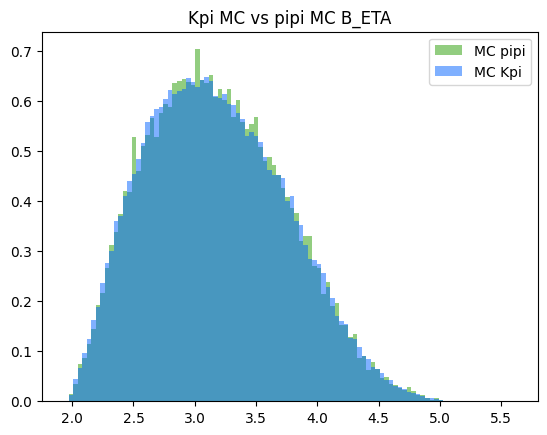

In [38]:
variableIndex = 3
variableKa = columns["kpi" ][variableIndex]
variablePi = columns["pipi"][variableIndex]


xLowerBound = min(list(dataframes["kpi"][variableKa]) + list(dataframes["pipi"][variablePi]))
xUpperBound = max(list(dataframes["kpi"][variableKa]) + list(dataframes["pipi"][variablePi]))

plt.hist(dataframes["pipi"][variablePi], range=(xLowerBound, xUpperBound), color=colors["pipi"],label="MC pipi",**histStyle)
plt.hist(dataframes["kpi"][variableKa], range=(xLowerBound, xUpperBound), color=colors["kpi"],label="MC Kpi",**histStyle)
plt.legend()
plt.title(f"Kpi MC vs pipi MC {columns['kpi'][variableIndex]}")
plt.savefig(f"../imgs/{columns['kpi'][variableIndex]}_MC")

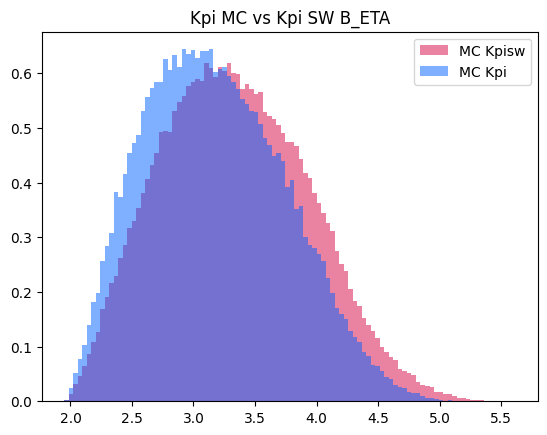

In [39]:
variableIndex = 3
variableKa = columns["kpi" ][variableIndex]


xLowerBound = min(list(dataframes["kpi"][variableKa]) )
xUpperBound = max(list(dataframes["kpi"][variableKa]) )

plt.hist(dataframes["kpisw"][variableKa], range=(xLowerBound, xUpperBound), color=colors["kpisw"],label="MC Kpisw",**histStyle)
plt.hist(dataframes["kpi"][variableKa], range=(xLowerBound, xUpperBound), color=colors["kpi"],label="MC Kpi",**histStyle)
plt.title(f"Kpi MC vs Kpi SW {columns['kpi'][variableIndex]}")
plt.legend()
plt.savefig(f"../imgs/{columns['kpi'][variableIndex]}_MCSW.png")

In [ ]:
#TODO
#implement aliases
#don't reweight too mant variables
#experiment with reweighting varaibles
#Implement Folding Reweighter
#plot ROC curve